In [33]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

Different methods to generate random points

In [34]:
def random_point_two_rands(
        x_min: float, x_max: float,
        y_min: float, y_max: float,
        f: lambda float: float
    ) -> tuple[float, float]:

    x = random.random() * (x_max - x_min) + x_min
    y = random.random() * (y_max - y_min) + y_min

    return (x,y)

def random_point_one_rand(
        x_min: float, x_max: float, 
        y_min: float, y_max: float,
        f: lambda float: float
    ) -> tuple[float]:
    
    x = random.random() * (x_max - x_min) + x_min
    y = f(x)

    return (x,y)

In [35]:
def general_2rand_points_generator(
        x_min: float, x_max: float,
        y_min: float, y_max: float,
        f: lambda float: float,
        rands_num: int
    ) -> list[tuple[float, float]]:

    points = []
    for _ in range(rands_num):
        points.append(random_point_two_rands(x_min, x_max, y_min, y_max, f))
    
    return points, ([], [])

def general_1rand_points_generator(
        x_min: float, x_max: float,
        y_min: float, y_max: float,
        f: lambda float: float,
        rands_num: int
    ) -> list[tuple[float, float]]:

    points = []
    for _ in range(2 * rands_num):
        points.append(random_point_one_rand(x_min, x_max, y_min, y_max, f))
    
    return points, ([], [])

def antithetic_2rand_points_generator(
        x_min: float, x_max: float,
        y_min: float, y_max: float,
        f: lambda float: float,
        rands_num: int
    ) -> list[tuple[float, float]]:

    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    points = []
    for _ in range(rands_num):
        x1, y1 = random_point_two_rands(x_min, x_max, y_min, y_max, f)
        x2 = x_mid - (x1 - x_mid)
        y2 = y_mid - (y1 - y_mid)
        points.append((x1, y1))
        points.append((x2, y2))
    
    return points, ([x_mid], [y_mid])

def antithetic_1rand_points_generator(
        x_min: float, x_max: float,
        y_min: float, y_max: float,
        f: lambda float: float,
        rands_num: int
    ) -> list[tuple[float, float]]:

    x_mid = (x_min + x_max) / 2
    points = []
    for _ in range(rands_num):
        x1, y1 = random_point_one_rand(x_min, x_max, y_min, y_max, f)
        x2 = x_max - (x1 - x_min)
        y2 = f(x2)
        points.append((x1, y1))
        points.append((x2, y2))
    
    return points, ([x_mid], [])

Calculate $\pi$ approximation using:
* ratio of points under the curve to total points
* average of function values for points


In [36]:
def sample_2d_approx(
        x_min: float, x_max: float, 
        y_min: float, y_max: float, 
        fun: lambda float: float,
        points: list[tuple[float, float]]
    ) -> float:

    n = len(points)
    inside = 0
    for point in points:
        if fun(point[0]) >= point[1]:
            inside += 1

    area = (x_max - x_min) * (y_max - y_min)
    approximation = (inside / n) * area

    return approximation

def sample_1d_approx(
    x_min: float, x_max: float, 
    y_min: float, y_max: float, 
    fun: lambda float: float,
    points: list[tuple[float, float]]
) -> float:
    
    n = len(points)
    approximation = sum(point[1] for point in points) * (x_max - x_min) / n

    return approximation

Visualisation of the points

In [37]:
def visualise(points: list[tuple[float, float]], divisions: list[list[float], list[float]], subtitle: str) -> None:
    _, ax = plt.subplots()

    outer_square = patches.Rectangle(
        (0, 0),
        width=1, height=1,
        edgecolor="green", facecolor="none",
        linewidth=1
    )
    ax.add_patch(outer_square)

    inner_square = patches.Rectangle(
        (0, 0),
        width=math.sqrt(2)/2, height=math.sqrt(2)/2,
        edgecolor="blue", facecolor="none",
        linewidth=1
    )
    ax.add_patch(inner_square)

    quarter_circle = patches.Wedge(
        center=(0, 0),
        r=1, theta1=0, theta2=90,
        edgecolor="blue", facecolor="none",
        linewidth=1
    )
    ax.add_patch(quarter_circle)

    for division in divisions[0]:
        ax.axvline(x=division, color="red", linestyle="--", linewidth=0.5)
    for division in divisions[1]:
        ax.axhline(y=division, color="red", linestyle="--", linewidth=0.5)

    for point in points:
        ax.plot(point[0], point[1], "o", color="blue" if (point[0]**2 + point[1]**2 <= 1 ) else "green")

    ax.set_aspect("equal", "box")
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    plt.suptitle(r"$\pi$ approximation")
    plt.title(subtitle)
    plt.show()

Sampling whole square [0,1]x[0,1]

In [45]:
def whole_square_approx(
    rands_num: int, 
    points_generator: callable,
    approx_calculator: callable,
    draw: bool,
    title: str
):
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    f = lambda x: math.sqrt(1 - x**2)

    points, layers = points_generator(
        x_min, x_max,
        y_min, y_max,
        f, rands_num
    )

    approximation = approx_calculator(x_min, x_max, y_min, y_max, f, points)
    area = 4 * approximation
    variance = (approximation - math.pi / 4) ** 2

    if draw:
        visualise(points, layers, title)
    else:
        print(f"Approximation: {area}")
        print(f"Variance: {variance}")

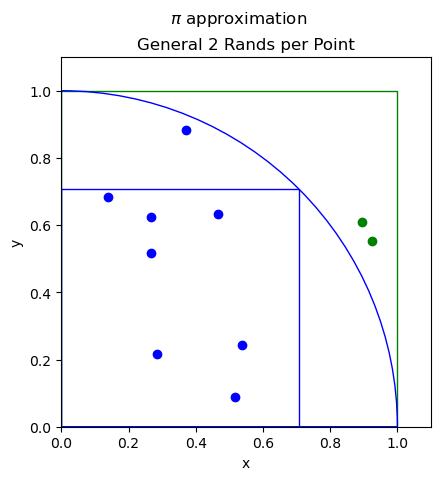

Approximation: 3.14908
Variance: 3.503772266652464e-06


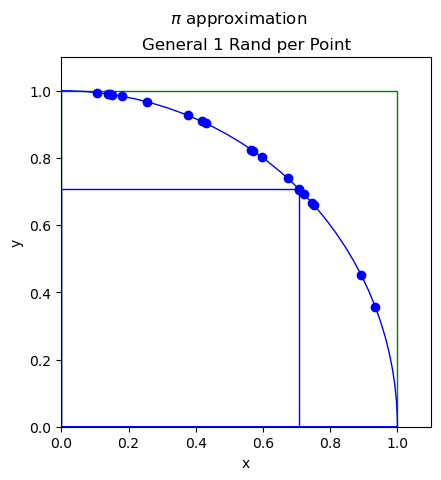

Approximation: 3.1436370292896934
Variance: 2.6121700014641126e-07


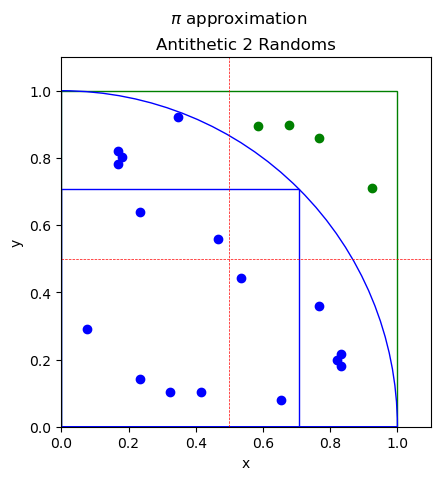

Approximation: 3.13786
Variance: 8.707939263372746e-07


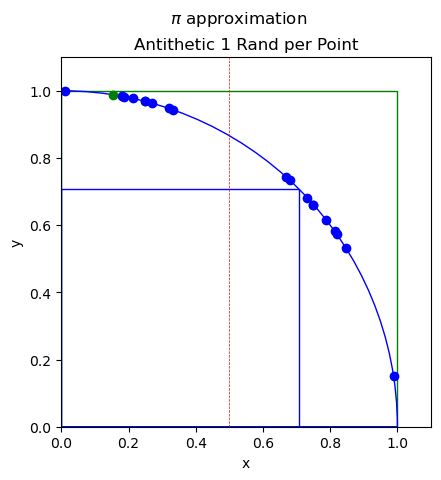

Approximation: 3.1439258311287257
Variance: 3.402323392612196e-07


In [47]:
RANDS_NUM_TO_DRAW = 10
RANDS_NUM_TO_CALC = 100000

whole_square_approx(
    RANDS_NUM_TO_DRAW, 
    general_2rand_points_generator,
    sample_2d_approx,
    draw=True,
    title="General 2 Rands per Point"
)
whole_square_approx(
    RANDS_NUM_TO_CALC, 
    general_2rand_points_generator,
    sample_2d_approx,
    draw=False,
    title=None
)

whole_square_approx(
    RANDS_NUM_TO_DRAW, 
    general_1rand_points_generator,
    sample_1d_approx,
    draw=True,
    title="General 1 Rand per Point"
)
whole_square_approx(
    RANDS_NUM_TO_CALC, 
    general_1rand_points_generator,
    sample_1d_approx,
    draw=False,
    title=None
)

whole_square_approx(
    RANDS_NUM_TO_DRAW, 
    antithetic_2rand_points_generator,
    sample_2d_approx,
    draw=True,
    title="Antithetic 2 Randoms"
)
whole_square_approx(
    RANDS_NUM_TO_CALC, 
    antithetic_2rand_points_generator,
    sample_2d_approx,
    draw=False,
    title=None
)

whole_square_approx(
    RANDS_NUM_TO_DRAW, 
    antithetic_1rand_points_generator,
    sample_1d_approx,
    draw=True,
    title="Antithetic 1 Rand per Point"
)
whole_square_approx(
    RANDS_NUM_TO_CALC, 
    antithetic_1rand_points_generator,
    sample_1d_approx,
    draw=False,
    title=None
)

Sampling only irregular parts 

In [42]:
def irregular_parts_approx(
    rands_num: int, 
    points_generator: callable,
    approx_calculator: callable,
    draw: bool,
    title: str
):
    x_min, x_max = math.sqrt(2) / 2, 1
    y_min, y_max = 0, math.sqrt(2) / 2
    f = lambda x: math.sqrt(1 - x**2)

    points, layers = points_generator(
        x_min, x_max,
        y_min, y_max,
        f, rands_num
    )

    approximation = approx_calculator(x_min, x_max, y_min, y_max, f, points)
    area = 4 * (0.5 + approximation * 2)
    variance = 2 * (approximation - (math.pi / 4 - 0.5) / 2) ** 2

    if draw:
        visualise(points, layers, title)
    else:
        print(f"Approximation: {area}")
        print(f"Variance: {variance}")

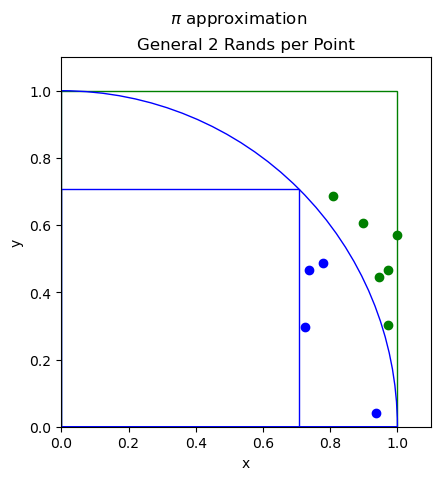

Approximation: 3.136751132034227
Variance: 3.662551714533095e-07


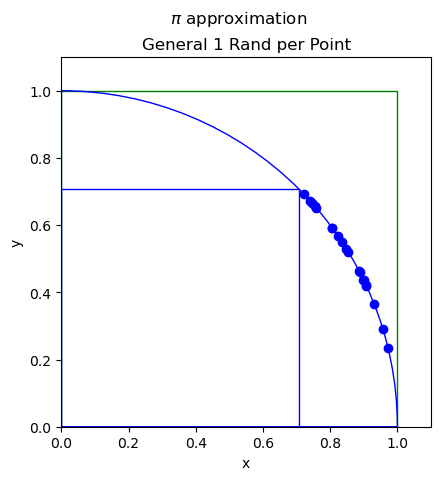

Approximation: 3.1421044979320154
Variance: 4.093509854140129e-09


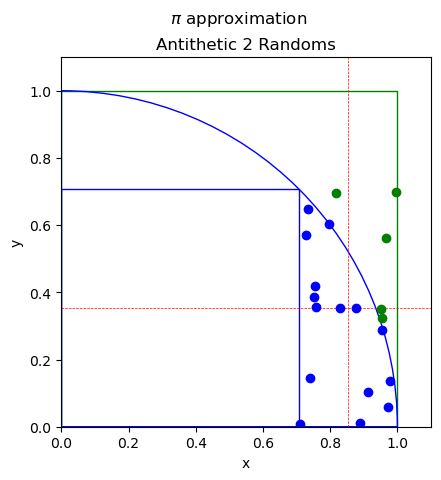

Approximation: 3.1398245966670357
Variance: 4.8844145032986104e-08


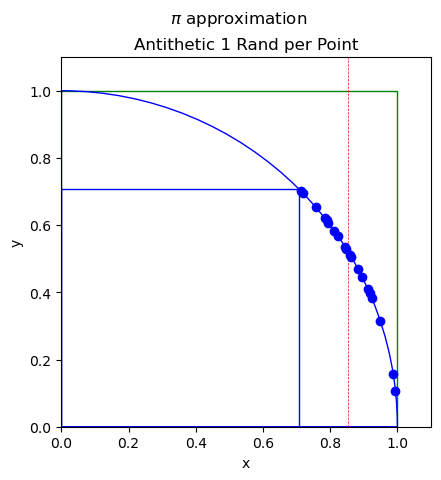

Approximation: 3.1416337266395242
Variance: 2.6359303347383327e-11


In [43]:
RANDS_NUM_TO_DRAW = 10
RANDS_NUM_TO_CALC = 100000

irregular_parts_approx(
    RANDS_NUM_TO_DRAW, 
    general_2rand_points_generator,
    sample_2d_approx,
    draw=True,
    title="General 2 Rands per Point"
)
irregular_parts_approx(
    RANDS_NUM_TO_CALC, 
    general_2rand_points_generator,
    sample_2d_approx,
    draw=False,
    title=None
)

irregular_parts_approx(
    RANDS_NUM_TO_DRAW, 
    general_1rand_points_generator,
    sample_1d_approx,
    draw=True,
    title="General 1 Rand per Point"
)
irregular_parts_approx(
    RANDS_NUM_TO_CALC, 
    general_1rand_points_generator,
    sample_1d_approx,
    draw=False,
    title=None
)

irregular_parts_approx(
    RANDS_NUM_TO_DRAW, 
    antithetic_2rand_points_generator,
    sample_2d_approx,
    draw=True,
    title="Antithetic 2 Randoms"
)
irregular_parts_approx(
    RANDS_NUM_TO_CALC, 
    antithetic_2rand_points_generator,
    sample_2d_approx,
    draw=False,
    title=None
)

irregular_parts_approx(
    RANDS_NUM_TO_DRAW, 
    antithetic_1rand_points_generator,
    sample_1d_approx,
    draw=True,
    title="Antithetic 1 Rand per Point"
)
irregular_parts_approx(
    RANDS_NUM_TO_CALC, 
    antithetic_1rand_points_generator,
    sample_1d_approx,
    draw=False,
    title=None
)